# Multiscale PV Recycling MILP

__author__ = "Natasha Jane Chrisandina, Funda Iseri, Rahul Kakodkar"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Natasha Jane Chrisandina", "Funda Iseri", "Rahul Kakodkar", "Efstratios N. Pistikopoulos"]
__maintainer__ = "Natasha Jane Chrisandina"
__email__ = "nchrisandina@tamu.edu"
__status__ = "Production"

## Problem Statement

The following case study considers one type of solar PV panel (crystalline silicon, c-Si) that is to be recycled into separate components. The goal is to maximize economic profit obtained from the recycling process.

Data source: https://www.sciencedirect.com/science/article/pii/S0927024822000162

Module imports

In [63]:
import sys
sys.path.append('src')

In [64]:
import pandas 
import numpy

from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.result import Result 
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
import matplotlib.pyplot as plt
from matplotlib import rc
from itertools import product
from energiapy.model.constraints.integer_cuts import constraint_block_integer_cut

## Define Temporal Scale

Define temporal scales at different levels:
- 0 is annual, with 1 discretization
- 1 is daily, with 365 discretization

In [65]:
scales = TemporalScale(discretization_list=[1, 365])

## Define Resources

Define resources, which are things to be consumed, produced, stored, or sold. In this case, the feedstock is silicon PV and the products are the different major recyclable materials. We will assume that *glass* is a product in demand, whereas everything else can simply be sold.

In [66]:
SiPV_dummy = Resource(name = 'sipv_dummy', label='Silicon PV Dummy', price=50, basis = 'module', cons_max=13000)
SiPV = Resource(name = 'sipv', label='Silicon Photovoltaic', price=50, basis = 'module')
glass = Resource(name = 'glass', label='Recycled glass', revenue=100, basis = 'kg')
aluminum = Resource(name = 'al', label='Recycled aluminum', revenue=100, basis = 'kg', sell=True)
polymer = Resource(name = 'polymer', label='Recycled polymer', revenue=100, basis = 'kg', sell=True)
copper = Resource(name = 'cu', label='Recycled copper', revenue=100, basis = 'kg', sell=True)
silver = Resource(name = 'ag', label='Recycled silver', revenue=100, basis = 'kg', sell=True)
silicon = Resource(name = 'si', label='Recycled silicon', revenue=100, basis = 'kg', sell=True)
glass_dummy = Resource(name = 'glass_dummy', label='Recycled glass Dummy', revenue=100, basis = 'kg', demand=True, varying = [VaryingResource.DETERMINISTIC_DEMAND])


## Define Processes

Define processes, which are the different potential recycling processes. There are three types of process: FRELP, ASU, and Hybrid, and each process has two separate max production level to represent large-scale vs small-scale recycling.

The "collection" process is essentially a dummy process to represent PVs being shipped off from a collection center to recycling center locations. Glass_collect is the same, except for glass which is a demanded product

In [67]:
collection = Process(name = 'collection', label='dummy process', conversion = {SiPV_dummy: -1, SiPV: 1}, prod_max = 130000, capex = 0.001)
glass_collect = Process(name = 'glass_collection', label='dummy process for product', conversion = {glass: -1, glass_dummy: 1}, prod_max = 10**6, capex = 0.001)


FRELP = Process(name = 'FRELP', label='FRELP recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.17945, silver: 0.001739}, prod_max = 1300, capex = 4, vopex = 8, block='A')
ASU = Process(name = 'ASU', label='ASU recycling', conversion = {SiPV: -1, glass: 13.73625, polymer: 2.22, aluminum: 1.5651, silicon: 0.4995, copper: 0.15355, silver: 0.001369}, prod_max = 1300, prod_min = 1, capex = 17, vopex = 9, block='A')
hybrid = Process(name = 'hybrid', label='Hybrid recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.15355, silver: 0.001369}, prod_max = 1300, capex = 3, vopex = 7, block='A')


FRELP_big = Process(name = 'FRELP_big', label='big FRELP recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.17945, silver: 0.001739}, prod_max = 13000, capex = 3, vopex = 5, block='A')
ASU_big = Process(name = 'ASU_big', label='big ASU recycling', conversion = {SiPV: -1, glass: 13.73625, polymer: 2.22, aluminum: 1.5651, silicon: 0.4995, copper: 0.15355, silver: 0.001369}, prod_max = 13000, capex = 8, vopex = 6, block='A')
hybrid_big = Process(name = 'hybrid_big', label='big Hybrid recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.15355, silver: 0.001369}, prod_max = 13000, capex = 3, vopex = 4, block='A')


## Define locations

In [68]:
import random 
demand_factor = pandas.DataFrame(data={'glass_dummy': [random.randrange(60, 100) for i in range(365)]})

In [69]:
cc1 = Location(name='cc1', label = 'Collection Center 1', scales = scales, processes = {collection})
cc2 = Location(name='cc2', label = 'Collection Center 2', scales = scales, processes = {collection})


rc1 = Location(name='rc1', label = 'Recycling Center 1', scales = scales, processes = {FRELP, ASU, hybrid, FRELP_big, ASU_big, hybrid_big})

gc1 = Location(name='gc1', label = 'Glass Recycling Center 1', scales = scales, processes= {glass_collect}, demand_factor= {glass_dummy: demand_factor}, demand_scale_level= 1)


## Define transportation modes

In [70]:
Trans_PV = Transport(name = 'Trans_PV', resources = {SiPV}, trans_max = 10**6, trans_cost = 0.01, label = 'Transport of PVs')
Trans_rec = Transport(name = 'Trans_rec', resources = {glass}, trans_max = 10**6, trans_cost = 0.01, label = 'Transport for recycled materials')


distance_matrix = [
    [100, 200],
    [100, 200],
    [0, 100]
    ]

transport_matrix = [
    [[Trans_PV], []],
    [[Trans_PV], []],
    [[], [Trans_rec]]
]


network = Network(name = 'Network', label= 'Generic network', source_locations = [cc1, cc2, rc1], sink_locations = [rc1, gc1], distance_matrix = distance_matrix, transport_matrix= transport_matrix)

## Define scenario. 

Glass recycling center has some level of demand that needs fulfilling

In [71]:
genericScenario = Scenario(name = 'genericScenario', network = network, scales= scales, demand={gc1: {glass_dummy: 10000}, rc1: {glass_dummy: 0}}, label = 'genericScenario', network_scale_level = 0, purchase_scale_level = 1, scheduling_scale_level = 1, demand_scale_level = 1, expenditure_scale_level = 0)

## Optimize for cost

In [72]:
milp_cost = formulate(scenario = genericScenario, constraints={Constraints.INVENTORY, Constraints.COST, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE, Constraints.TRANSPORT, Constraints.NETWORK}, objective=Objective.COST)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint location vopex
constraint location incidental
constraint network capex
constraint network fopex
constraint network vopex
constraint network incidental
constraint nameplate inventory
constraint storage max
constraint storage min
constraint production mode
constraint nameplate production
constraint production max
constraint production min
constraint inventory balance
constraint resource consumption
constraint resource purchase
constraint location production
constraint location discharge
constraint location consumption
constraint location purchase
constraint network production
constraint network discharge
constraint network consumption
constraint network purchase
constraint transport export
constraint transport import
constraint transport exp UB
constraint transport imp UB
constraint transport balance
constraint transport i

In [73]:
results_cost = solve(scenario = genericScenario, instance=milp_cost, solver='gurobi', print_solversteps=True, name = 'results')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 80626 rows, 79877 columns and 221425 nonzeros
Model fingerprint: 0xd95077d4
Variable types: 79833 continuous, 44 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+06]
Presolve removed 80264 rows and 79588 columns
Presolve time: 0.10s
Presolved: 362 rows, 289 columns, 1124 nonzeros
Variable types: 288 continuous, 1 integer (1 binary)
Found heuristic solution: objective 1.497424e+07

Root relaxation: cutoff, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

## Optimize for demand

In [74]:
milp_demand = formulate(scenario = genericScenario, constraints={Constraints.INVENTORY, Constraints.COST, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE, Constraints.TRANSPORT, Constraints.NETWORK}, objective=Objective.MAX_DISCHARGE, objective_resource = glass_dummy)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint location vopex
constraint location incidental
constraint network capex
constraint network fopex
constraint network vopex
constraint network incidental
constraint nameplate inventory
constraint storage max
constraint storage min
constraint production mode
constraint nameplate production
constraint production max
constraint production min
constraint inventory balance
constraint resource consumption
constraint resource purchase
constraint location production
constraint location discharge
constraint location consumption
constraint location purchase
constraint network production
constraint network discharge
constraint network consumption
constraint network purchase
constraint transport export
constraint transport import
constraint transport exp UB
constraint transport imp UB
constraint transport balance
constraint transport i

Specify that only one process gets chosen in RC1

Integer cut constraints can also be used to indicate that we need at least/at most X many processes in this location

In [75]:
# milp_demand.constraint_block_integer_cut1 = constraint_block_integer_cut(
#     instance=milp_demand, network_scale_level=0, location=rc1, block='A', number=1, process_set=rc1.processes)

In [76]:
results_demand = solve(scenario = genericScenario, instance=milp_demand, solver='gurobi', print_solversteps=True, name = 'results')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 80627 rows, 79877 columns and 221433 nonzeros
Model fingerprint: 0xc5631824
Variable types: 79833 continuous, 44 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+06]
Presolve removed 80627 rows and 79877 columns
Presolve time: 0.07s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.12 seconds (0.10 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 1.29764e+08 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.297644806250e+08, best bound 1.297644806250e+08, gap 0.0000%


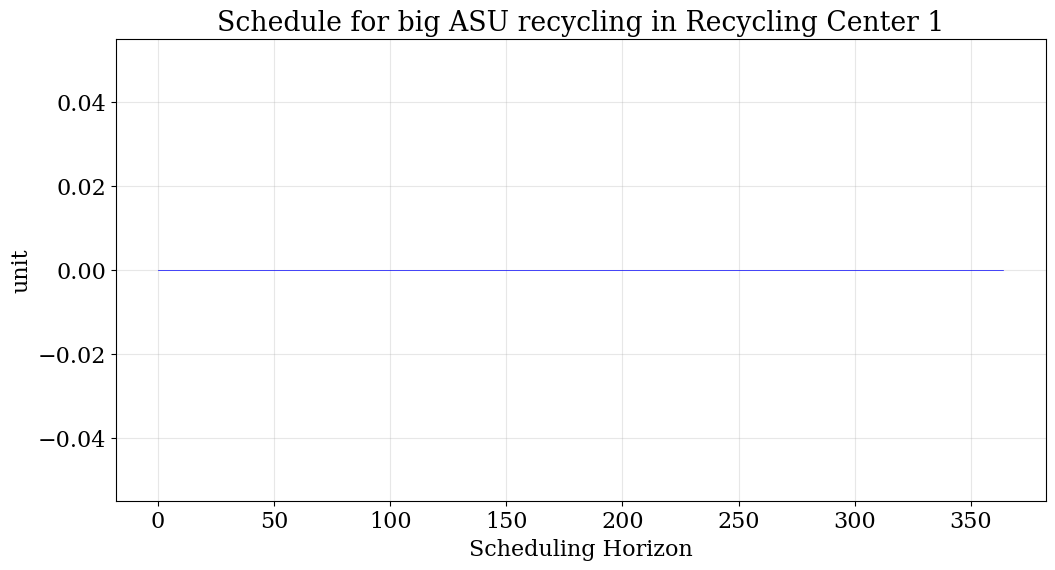

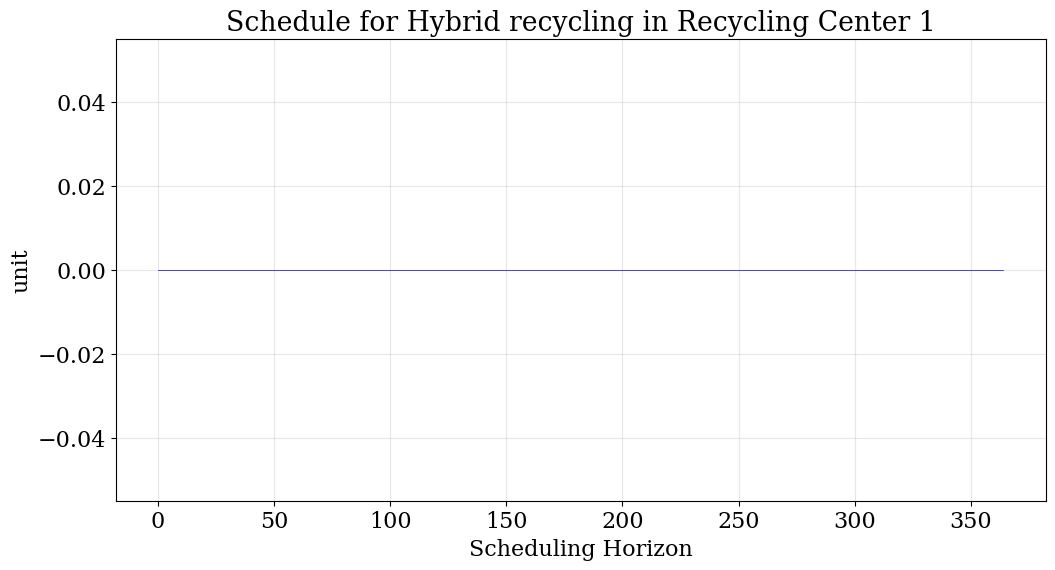

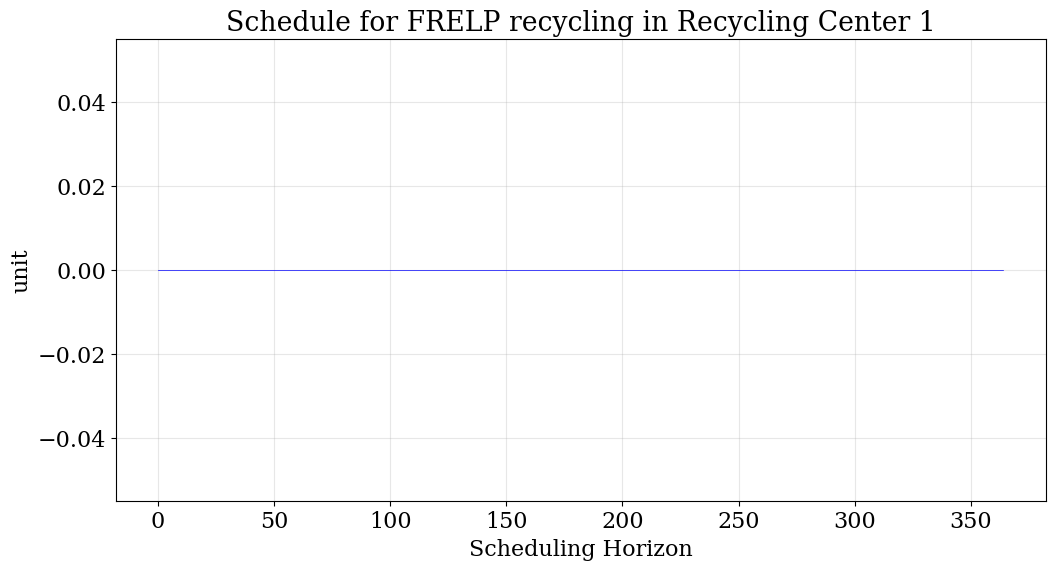

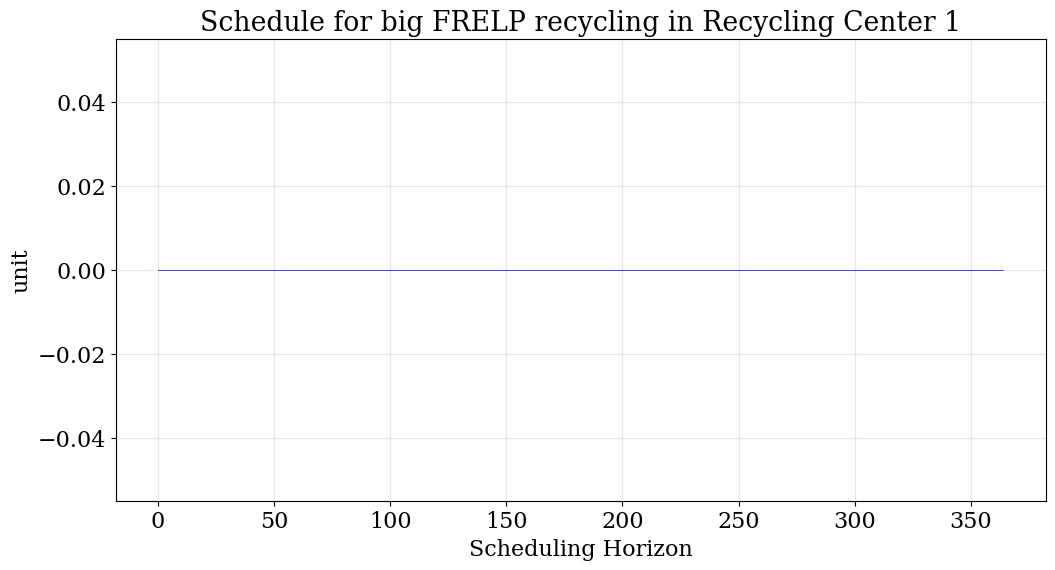

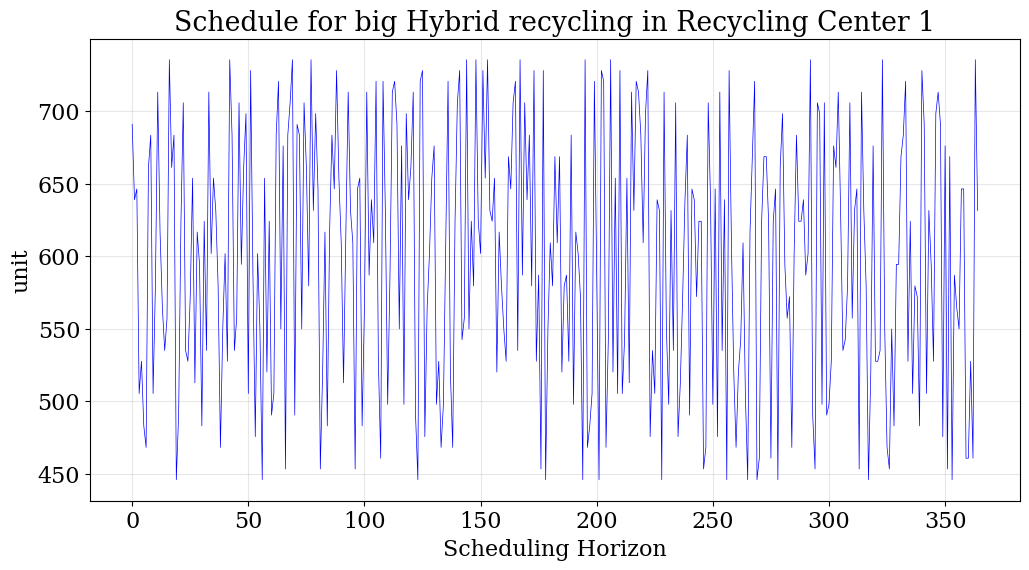

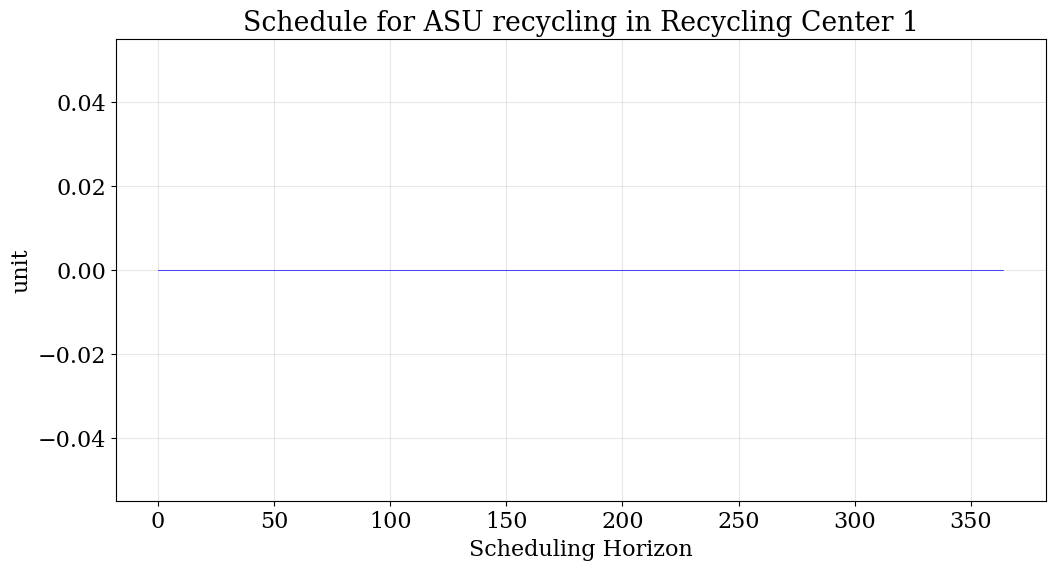

In [77]:
for i in {FRELP, ASU, hybrid, FRELP_big, ASU_big, hybrid_big}:
    plot_results.schedule(location = 'rc1', component = i.name, results = results_cost, y_axis = 'P')

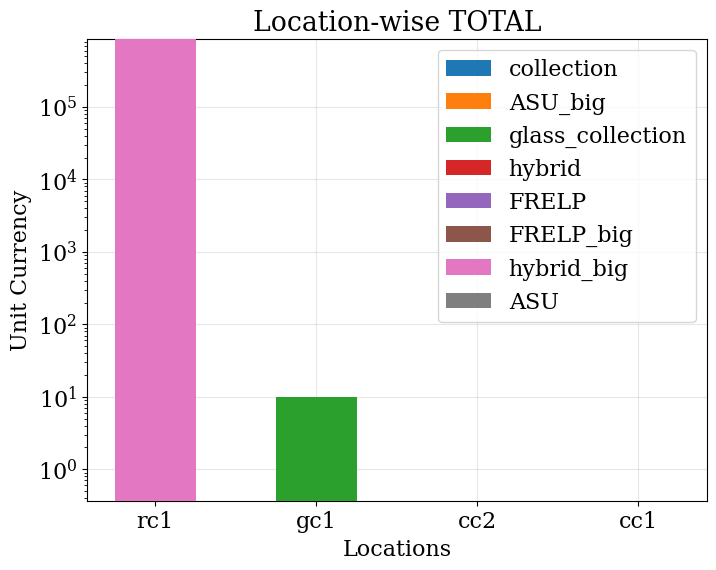

In [78]:
plot_results.cost(results=results_cost, x=CostX.LOCATION_WISE,
                  y=CostY.TOTAL, location='rc1', fig_size=(8, 6))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 735.4293068578783, 0.0]


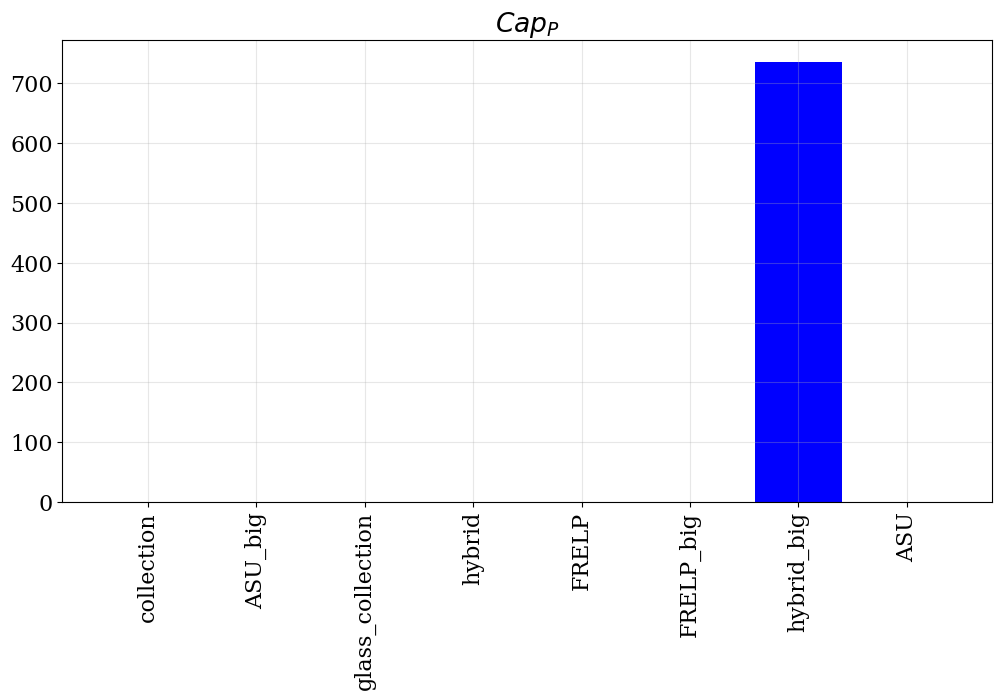

In [82]:
plot_results.contribution(results= results_cost, location= 'rc1', y_axis= 'Cap_P')

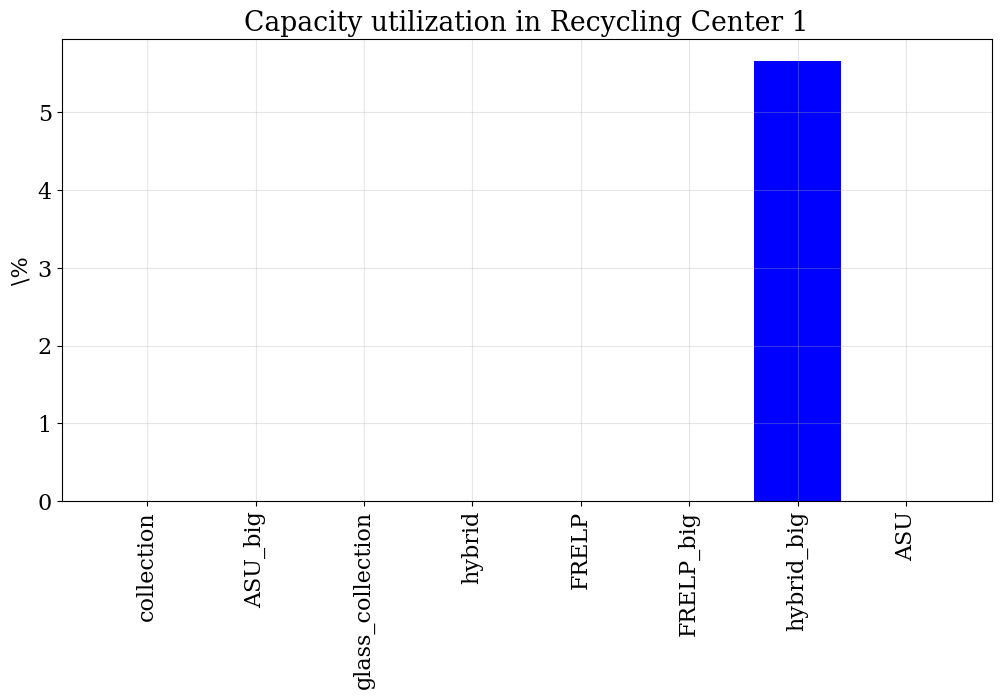

In [84]:
plot_results.capacity_utilization(results=results_cost, location='rc1')

In [86]:
735.4293068578783/13000

0.05657148514291371

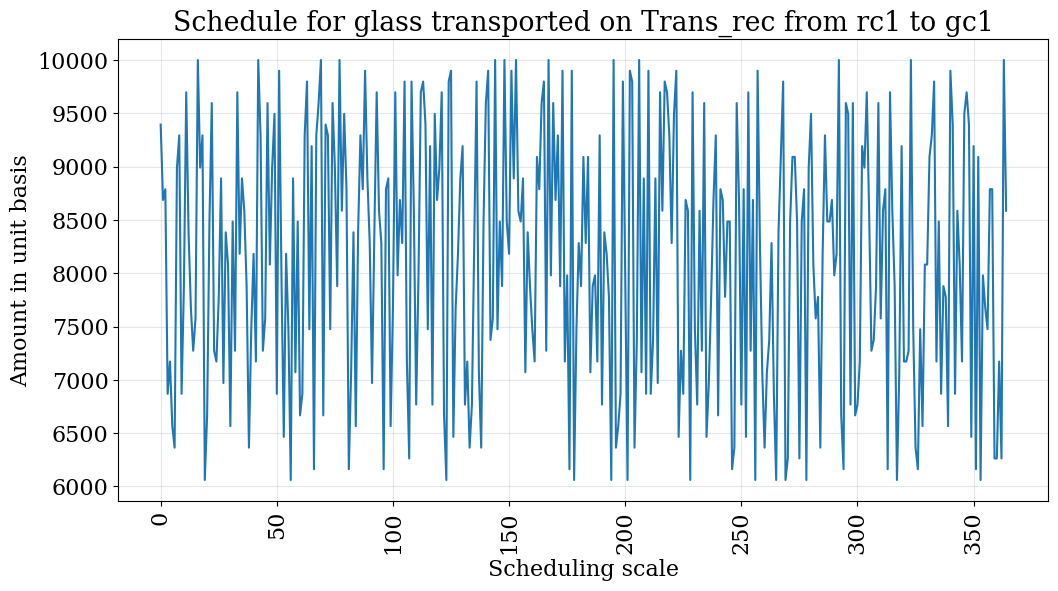

In [89]:
plot_results.transport(results=results_cost, source= 'rc1', sink = 'gc1', resource= 'glass', transport='Trans_rec')